In [1]:
import numpy as np
import torch 
import h5py # pour gérer les formats de données utilisés ici 
import matplotlib.pyplot as plt
from numpy.fft import fft
import seaborn as sns
from collections import Counter
from torch.utils.data import DataLoader
from torch.utils.data import Dataset





# TP3: Reconnaissance de signaux de communication par apprentissage profond 

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp3.ipynb 

2 séances de TP sur ce sujet : le 6 novembre (1h00), le 13 novembre (3h). 
Le cours du 19 novembre sera partagé en 3 : cours sur la séparation de sources audio / présentation des mini projets et organisation des soutenances / fin de ce TP.<br> 
Deadline pour le rendu du TP: 26 novembre 2024, 13h59, par mail à deepetsignal.mva@gmail.com <br> 

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook 
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook. 
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.

## Problématique

On cherche à identifier un type d'émetteur de communication à partir de l'observation d'un signal provenant de l'émetteur 
de 2048 échantillons IQ (In Phase / Quadrature) ie le signal prend des valeurs complexes. On représente la partie 
réelle et la partie imaginaire du signal par deux canaux réel d'un signal multivarié. 

L'émetteur peut provenir de 6 catégories différentes. 
Les paramètres différenciant les différentes catégories sont 
- le type de modulation 
- la présence ou non de séquences pilotes et le cas échéant la structure de trame pilotes / données 
- le débit de la transmission 

Les signaux se propagent en champs libre et sont enregistrés par une antenne. Le signal reçu est transposé en bande de base c'est à dire que si le signal est transmis autour d'une fréquence centrale f0, une première étape de traitement du signal à la réception recentre le signal autour de la fréquence 0. 


Les différents signaux observés dans ce TP sont entachés de différentes erreurs caractéristiques de la propagation 
électromagnétique comme : 
- modification aléatoire de la phase du signal lors de la transmission
- imperfection de la transposition en bande de base qui laisse le signal transposé à une fréquence df0 << f0
- présence d'interférence entre les symboles transmis (dûes par exemple à plusieurs chemins de propagation)
- présence d'un bruit blanc additif gaussien

Le niveau du bruit relativement à celui du signal utile est décrit par le SNR (Signal to Noise Ratio) et exprimé en dB. On suppose que le SNR est connu lors de l'acquisition d'un signal. Lors de ce TP nous rencontrerons 4 niveaux de SNR: 30 dB (facile), 20 dB, 10 dB et 0 dB (en espérant qu'on puisse faire quelque chose de ces données). 
Un de nos objectifs sera de qualifier la performance des algorithmes mis en place en fonction du SNR.

Les objectifs de ce TP sont: 

1. Définir une ou plusieurs architectures de réseaux de neurones profonds et les implémenter en PyTorch
2. Entrainer ces architectures, la fonction de perte employée pourra être la log vraisemblance négative: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html. 
3. Qualifier les performances de votre réseau de neurones sur l'ensemble de test via: 
   - Le calcul de l'accuracy implémentée par exemple dans le package TorchMetrics (https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
   - La réalisation d'un graphique accuracy vs SNR 
   - La réalisation des matrices de confusion entre les différentes classes pour les différents SNR (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
4. Rapporter les performances de vos architectures à leur complexité, la complexité d'un réseau de neurones étant ici résumé au nombre de paramètres libres qu'il fait intervenir

Durant l'entraînement on observera l'évolution de la fonction de perte et de l'accuracy sur l'ensemble d'entraînement et sur l'ensemble de validation. 


Les 4 premières parties sont un échauffement sur lequel vous pouvez passer vite si vous êtes à l'aise avec le sujet. 
Le gros du travail est dans la partie 5 "Entraînemenent d'un réseau de neurones". 

Surtout privilégiez dans un premier temps la simplicité quitte à complexifier votre approche ensuite pour doper ses performances. Ne restez pas bloqué sur des réseaux qui "mettent trop de temps à apprendre"

## Chargement des données en numpy

Le TP est composé de trois jeux de données : 
- train.hdf5 destiné à nourrir l'entrainement de réseaux de neurones 
- test.hdf5 destiné à évaluer les algorithmes après entrainement
- samples.hdf5 qui est beaucoup plus petit que train.hdf5 et destiné à servir de modèle de données dans une phase de prototypage 
des algorithmes et de la pipeline d'entrainement

Les trois jeux de données sont au format hdf5 qui peut être manipulé via l'API Python h5py https://docs.h5py.org/en/stable/quick.html.
Un fichier hdf5 est consitué d'une arborescence de datasets et de groups. Un dataset hdf5 représente un tenseur n dimensionnel. Un dataset se convertit très facilement en numpy array.

Par exemple vous pouvez charger les données samples selon la cellule suivante:

In [2]:
data_path = 'train.hdf5'

data = h5py.File(data_path , 'r')

signals = np.array(data['signaux'])
snr =  np.array(data['snr'])
labels_id = np.array(data['labels'])

data.close()

Vous pouvez récupérer le nom de la correspondance entre un label et le nom du standard d'émetteur correspondant via:

In [3]:
def get_labels(open_h5_file): 
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }

### Visualisation des données 

Commencez par étudier les données: 

    - observez leur taille 
    - la distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement 
    - visualisez quelques signaux bien choisis selon une ou des représentations que vous choisirez 

Remarque : dans ce TP il n'y a pas beaucoup à gagner à faire du feature engineering 

Dimensions des données:
Signals shape: (30000, 2048, 2)
SNR shape: (30000,)
Labels shape: (30000,)


<Figure size 1400x600 with 0 Axes>

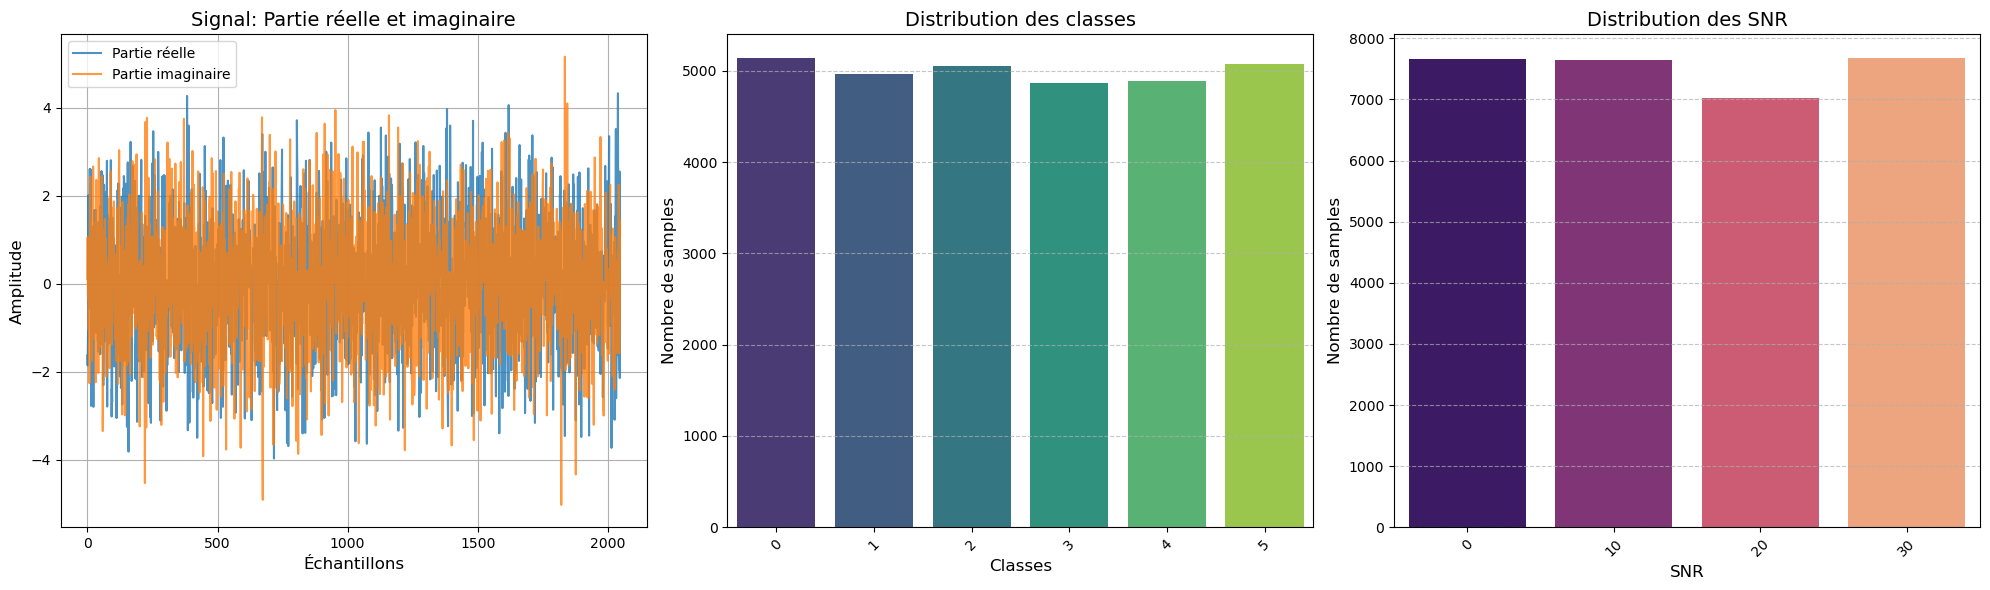

Classes: [0 1 2 3 4 5]
Nombre de classes: 6
Nombre de samples par classe: Counter({0: 5143, 5: 5075, 2: 5053, 1: 4968, 4: 4894, 3: 4867})
Distribution des SNR: Counter({30: 7680, 0: 7660, 10: 7640, 20: 7020})
SNRs: [ 0 10 20 30]
Nombre de SNRs: 4
Nombre de samples par SNR: Counter({30: 7680, 0: 7660, 10: 7640, 20: 7020})


In [4]:

# Exemple des dimensions des données
print("Dimensions des données:")
print(f"Signals shape: {signals.shape}")
print(f"SNR shape: {snr.shape}")
print(f"Labels shape: {labels_id.shape}")

# Plot d'un signal (partie réelle et imaginaire)
plt.figure(figsize=(14, 6))
real_part = signals[0, :, 0]
imag_part = signals[0, :, 1]

labels = labels_id
classes = np.unique(labels)
counts_classes = Counter(labels)

snrs = np.unique(snr)
counts_snrs = Counter(snr)


# Création de la figure avec plusieurs sous-graphiques côte à côte
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1 : Partie réelle et imaginaire
axes[0].plot(real_part, label='Partie réelle', alpha=0.8)
axes[0].plot(imag_part, label='Partie imaginaire', alpha=0.8)
axes[0].set_title('Signal: Partie réelle et imaginaire', fontsize=14)
axes[0].set_xlabel('Échantillons', fontsize=12)
axes[0].set_ylabel('Amplitude', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True)

# Plot 2 : Distribution des classes
sns.barplot(x=list(counts_classes.keys()), y=list(counts_classes.values()), ax=axes[1], palette="viridis")
axes[1].set_title('Distribution des classes', fontsize=14)
axes[1].set_xlabel('Classes', fontsize=12)
axes[1].set_ylabel('Nombre de samples', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 3 : Distribution des SNR
sns.barplot(x=list(counts_snrs.keys()), y=list(counts_snrs.values()), ax=axes[2], palette="magma")
axes[2].set_title('Distribution des SNR', fontsize=14)
axes[2].set_xlabel('SNR', fontsize=12)
axes[2].set_ylabel('Nombre de samples', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

# Ajustement des espacements
plt.tight_layout()
plt.show()

# Affichage des statistiques
print(f"Classes: {classes}")
print(f"Nombre de classes: {len(classes)}")
print(f"Nombre de samples par classe: {counts_classes}")
print(f"Distribution des SNR: {counts_snrs}")

print(f"SNRs: {snrs}")
print(f"Nombre de SNRs: {len(snrs)}")
print(f"Nombre de samples par SNR: {counts_snrs}")




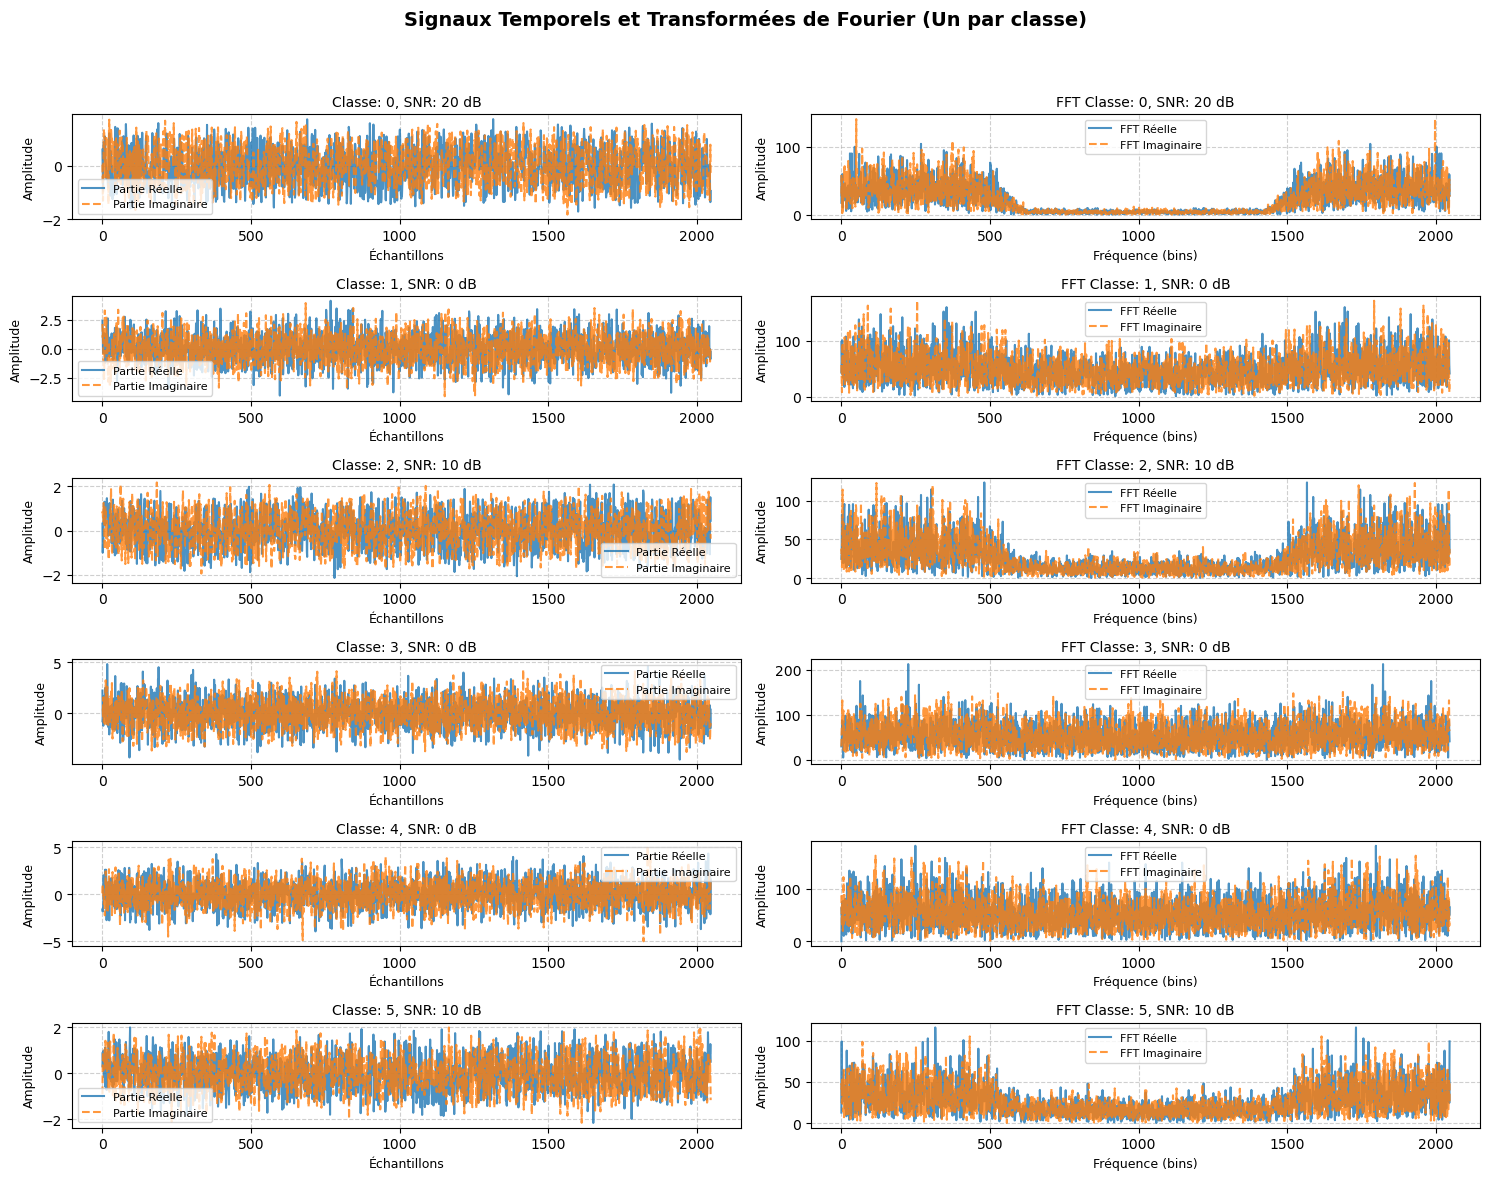

In [60]:

# Sélection d'un signal unique par classe
unique_classes = np.unique(labels)
signals_per_class = [signals[np.where(labels == c)[0][0]] for c in unique_classes]
snr_per_class = [snr[np.where(labels == c)[0][0]] for c in unique_classes]

# Plot des signaux temporels
plt.figure(figsize=(15, len(unique_classes) * 2))
for idx, (signal, cls, snr_value) in enumerate(zip(signals_per_class, unique_classes, snr_per_class)):
    plt.subplot(len(unique_classes), 2, 2 * idx + 1)
    plt.plot(signal[:, 0], label='Partie Réelle', alpha=0.8)
    plt.plot(signal[:, 1], label='Partie Imaginaire', alpha=0.8, linestyle='--')
    plt.title(f'Classe: {cls}, SNR: {snr_value} dB', fontsize=10)
    plt.xlabel('Échantillons', fontsize=9)
    plt.ylabel('Amplitude', fontsize=9)
    plt.legend(fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.6)

# Plot des transformées de Fourier
for idx, (signal, cls, snr_value) in enumerate(zip(signals_per_class, unique_classes, snr_per_class)):
    plt.subplot(len(unique_classes), 2, 2 * idx + 2)
    plt.plot(np.abs(fft(signal[:, 0])), label='FFT Réelle', alpha=0.8)
    plt.plot(np.abs(fft(signal[:, 1])), label='FFT Imaginaire', alpha=0.8, linestyle='--')
    plt.title(f'FFT Classe: {cls}, SNR: {snr_value} dB', fontsize=10)
    plt.xlabel('Fréquence (bins)', fontsize=9)
    plt.ylabel('Amplitude', fontsize=9)
    plt.legend(fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Signaux Temporels et Transformées de Fourier (Un par classe)', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Chargement des données en Pytorch

Pour entrainer des réseaux de neurones profond sur nos données nous allons utiliser le framework Pytorch. 
Une première étape va consister à transférer les données de numpy à PyTorch, cela passe par deux objets : 
    - un Dataset qui modélise le dataset à haut niveau dans la mémoire de l'ordinateur
    - un Dataloader qui permet d'échantillonner le Dataset Pytorch dans les itérations de l'optimisation du réseau de neurones 
    
Un dataset prend la forme 
```python
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_data):
        ...
    def __len__(self): #retourne le nombre de données dans le dataset
        ...
    def __getitem__(self,i): #retourne pour chaque indice i un couple (data_i, lablel_i), data_i étant un signal et label_i le label associé au signal
        ...
```

Implémentez une classe Dataset pour le dataset considéré ici 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_data):
        self.data = h5py.File(path_to_data , 'r')
        #inverser les deux dimensions dans data['signaux'] pour les avoir de la forme [B,C,T]
        signaux = np.array(self.data['signaux']).transpose(0,2,1)
        self.signals = torch.tensor(signaux).to(device)
        self.snr =  torch.tensor(self.data['snr']).to(device)
        #One hot encoding des labels
        labels = np.array(self.data['labels'])
        one_hot_labels = np.zeros((labels.size, labels.max()+1))
        one_hot_labels[np.arange(labels.size), labels] = 1
        self.labels = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)
    def __len__(self): #retourne le nombre de données dans le dataset
        return len(self.signals)
    def __getitem__(self,i): #retourne pour chaque indice i un couple (data_i, lablel_i), data_i étant un signal et label_i le label associé au signal
        return self.signals[i], self.snr[i], self.labels[i]

Instanciez un objet dataset et testez le sur les données samples
```python
dataset = MyDataset(...)
```

In [5]:
dataset = MyDataset('train.hdf5')

Pytorch propose une classe Dataloader qui permet d'échantillonner des batchs de taille fixe à partir d'un dataset. 
La cellule suivante donne un exemple d'utilisation

In [6]:


dataloader = DataLoader(dataset, 
                        batch_size=10, 
                        shuffle=True
                       )

val_loader = DataLoader(MyDataset('validation.hdf5'), 
                        batch_size=10, 
                        shuffle=True
                       )

test_loader = DataLoader(MyDataset('test.hdf5'), 
                        batch_size=10, 
                        shuffle=True
                       )

Testez le dataloader pour différentes valeurs de batch_size 

In [64]:
# tester le dataloader
for i, (signals, snr, labels) in enumerate(dataloader):
    print(signals.shape, snr.shape, labels.shape)
    if i == 0:
        break

dataloader = DataLoader(dataset,batch_size=20,shuffle=True)

#tester le dataloader
for i, (signals, snr, labels) in enumerate(dataloader):
    print(signals.shape, snr.shape, labels.shape)
    if i == 0:
        break

torch.Size([10, 2, 2048]) torch.Size([10]) torch.Size([10, 6])
torch.Size([20, 2, 2048]) torch.Size([20]) torch.Size([20, 6])


## Mise en place d'un réseau "dumb" pour tester la pipeline d'entrainement

Définissez un premier modèle Pytorch qui prend en entrée un batch de données (tenseur de dimensions [B , C, T] avec B la taille du batch, C le nombre de canaux des signaux et T le nombre d'échantillons dans les signaux) et renvoie un batch de vecteur de probabilités (ou de log probabilités si vous préférez) (tenseur de dimensions [B,N] où N est le nombre de classe à identifier). 

Ce modèle doit comporter moins de 10000 paramètres libres. 

Ce Modèle doit être très simple, il doit être rapide à exécuter, il servira à tester et éventuellement débugger la pipeline d'entrainement que vous mettrez en place un peu plus loin. Un template d'implémentation d'une classe Model se trouve dans les diapositives du cours.

In [7]:
class MyDumbModel(torch.nn.Module):
    
    def __init__(self):
        super(MyDumbModel, self).__init__()
        self.fc1 = torch.nn.Linear(2048, 2) # Nous faisons une couche linéaire d'une dimension de départ de T = 2048 vers une dimension très faible donc 2 ici
        self.fc2 = torch.nn.Linear(2048, 2) # car nous voulons avoir un minimum de paramètre (- de 10000) et il y a T * 2 = 4096 paramètres dans celles-ci
        self.fc3 = torch.nn.Linear(5,6) #Dernière couche linéaire pour avoir un vecteur de coefficients au final, comme le nombre de classe
        
    def forward(self, x1, x2, snr):
        x1 = torch.relu(self.fc1(x1))
        x2 = torch.relu(self.fc2(x2))
        x = torch.concat([x1,x2], dim=1)
        snr = snr.unsqueeze(1) 
        x = torch.concat([x,snr], dim=1)# Ajout du snr dans le vecteur
        x = self.fc3(x) # Mise du vecteur en dimension 6, car nous avons 6 classes
        return torch.softmax(x, dim=1) # Nous voulons des probas d'appartenir à une classe en sortie

Instanciez votre modèle et testez la consistence de ses entrées / sorties vis à vis des données étudiées (test purement fonctionnel, pas besoin de chercher à réaliser un entraînement à ce point).

In [10]:
model = MyDumbModel().to(device)
signals, snr, labels = next(iter(dataloader))
print(signals.shape, snr.shape)
print(signals[:,0,:].device, snr.device, signals[:,1,:].device)
output = model(signals[:,0,:], signals[:,1,:], snr)
print(output.shape)

torch.Size([10, 2, 2048]) torch.Size([10])
cuda:0 cuda:0 cuda:0
torch.Size([10, 6])


Estimez par un calcul "théorique" le nombre de paramètres du modèle que vous avez défini et vérifié que le modèle a bien ce nombre de paramètres en pratique par exemple en utilisant la fonction suivante : 

In [11]:
def count_n_param(model):
    return sum([p.numel() for p in model.parameters()])

In [12]:
count_n_param(model)

8232

Nous avons donc bien moins de 10 000 paramètres comme demandé.

## Mise en place de la pipeline d'entraînement

La pipeline d'entrainement consiste à 
- charger les données 
- les batcher 
- réaliser des itération (epochs) de descente de gradient pour optimiser les paramètres d'un algorithme selon une fonction de perte (loss)
- logger l'évolution au fil des epochs  de la loss sur l'ensemble train et l'ensemble de validation et éventuellement de métriques complémentaires 

Un cavnevas d'implémentation pourrait être:

```python
device = 'cpu' # set so 'cuda:xx' if you have a GPU, xx is GPU index. L'entraînement des réseaux de neurones est grandement accéléré par l'utilisation d'un GPU 

model = ...  # vous instanciez ici votre modèle

loss = .... # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = ... # le nombre d'itérations dans l'entrainement 

chemin_vers_sauvegarde_model = # chemin vers un fichier où vous sauvegarderez votre modèle après optimisation pour le réutiliser plus tard. 

model.to(device) # on place le modèle dans le GPU si nécessaire

for epoch in range(n_epochs):
    
    for batch_x,batch_y in dataloader_train:
        
        batch_x.to(device)
        batch_y.to(device)
        
        optimizer.zero_grad()
        
        batch_y_predicted = model(batch_x)
        
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
        
        optimizer.step()
        
    for batch_x,batch_y in dataloader_valid:
        
        batch_x.to(device)
        batch_y.to(device)
        
        with torch.no_grad():
            batch_y_predicted = model(batch_x)  
            
        # loggez la loss et les métriques sur le batch de validation

torch.save(model, chemin_vers_sauvegarde_model)

```

Mettez en place votre pipeline et testez là sur votre modèle dumb. Faites en sorte que votre façon de logger les loss et les métriques vous permette de visualiser l'évolution de ces différents indicateurs sur l'ensemble d'entrainement et de validation au fil des epochs. 

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = MyDumbModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

# Training loop
n_epochs = 20
val_losses = []
for epoch in range(n_epochs):
    model.train()
    for signals, snr, labels in dataloader:
        signals = signals.to(device)
        snr = snr.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(signals[:,0,:], signals[:,1,:], snr)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    #Boucle de validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for signals, snr, labels in val_loader:
            signals = signals.to(device)
            snr = snr.to(device)
            labels = labels.to(device)
            output = model(signals[:,0,:], signals[:,1,:], snr)
            val_loss += criterion(output, labels).item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        if len(val_losses)>1:
            if val_losses[-2] < val_losses[-1]:  # On veut s'arrêter si la loss de validation diminue, car cela est un signe que l'on commence à faire du
                print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}, Val Loss: {val_loss}') #surapprentissage, surtout pour un modèle simple.
                break
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}, Val Loss: {val_loss}')

# Boucle de test

model.eval()

with torch.no_grad():
    test_loss = 0
    correct = 0
    total = 0


    for signals, snr, labels in test_loader:
        signals = signals.to(device)
        snr = snr.to(device)
        labels = labels.to(device)
        output = model(signals[:,0,:], signals[:,1,:], snr)
        test_loss += criterion(output, labels).item()
        #Accuracy
        _, predicted = torch.max(output, 1)  
        _, labels = torch.max(labels, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy: {correct / total}')
    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss}')


cuda
Epoch 1/20, Loss: 0.4309667944908142, Val Loss: 0.4473709678947926
Epoch 2/20, Loss: 0.45003625750541687, Val Loss: 0.4456876249909401
Epoch 3/20, Loss: 0.42547813057899475, Val Loss: 0.4496992010176182
Accuracy: 0.2149
Test Loss: 0.450564215362072


Nous avons une Accuracy de $0.21$, ce qui est légèrement mieux que de l'aléatoire pur qui se situe autour de $0.16$ car il y a 6 classes. Cela constitue donc notre point de référence pour nos futurs modèles plus élaborés.

Vérifiez que vous avez bien enregistré votre modèle en fin d'entrainement. Chargez le avec la fonction 
```python
modele = torch.load(...) 
```
et vérifiez que vous pouvez l'utiliser sur des données du problème.

## Entraînement de réseaux de neurones

Dans cette partie vous définissez une ou plusieurs architecture de réseaux de neurones profonds et vous les réglez sur les données d'entrainement. 
Vous pouvez notamment utiliser des réseaux à base de convolutions et/ou de couches réurrentes. Vous pouvez vous inspirer de ce qui a été dit en cours sur la reconnaissance vocale.

Dans un deuxième temps (facultatif), si vous le souhaitez vous pouvez mettre en place des stratégies d'augmentation de données pour améliorer vos résultats. Pour mettre l'augmentation de données en pratique pouvez vous renseigner sur l'argument collate_fn du dataloader standard de Pytorch. 

Nous allons donc dans un premier temps faire une augmentation de données pour étoffer nos données d'entraînement. Cela nous permettra de complexifier notre modèle en augmentant le nombre de paramètre (avec des couches de convolution plus grandes par exemple), tout en assurant son entrainement. Pour cela nous allons prendre les signaux que nous avons à disposition et effectuer les opérations suivantes sur ceux-ci:
- Ajouter du bruit blanc 
- Ajouter un décalage à notre signal
- Modifier l'amplitude du signal (aléatoirement)

In [14]:


class AugmentedSignalDataset(Dataset):
    def __init__(self, path_to_data, num_augmented_copies=2, device='cuda'):
        # Charger les données depuis le fichier HDF5
        self.data = h5py.File(path_to_data, 'r')
        
        # Inverser les deux dernières dimensions dans data['signaux']
        signaux = np.array(self.data['signaux']).transpose(0, 2, 1)
        original_signals = torch.tensor(signaux, dtype=torch.float32).to(device)
        
        # Charger le SNR et les labels
        snr = torch.tensor(self.data['snr'], dtype=torch.float32).to(device)
        labels = np.array(self.data['labels'])
        
        # Encodage one-hot des labels
        num_classes = labels.max() + 1
        one_hot_labels = np.zeros((labels.size, num_classes))
        one_hot_labels[np.arange(labels.size), labels] = 1
        one_hot_labels = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

        #Encodage one-hot des snr
        num_snr = 0
        snrs = []
        for i in range(len(snr)):
            if snr[i] not in snrs:
                snrs.append(snr[i])
                num_snr += 1
        one_hot_snr = np.zeros((len(snr), num_snr))
        for i in range(len(snr)):
            one_hot_snr[i][snrs.index(snr[i])] = 1
        one_hot_snr = torch.tensor(one_hot_snr, dtype=torch.float32).to(device)
        
        # Initialiser les listes pour les signaux, SNR et labels
        all_signals = [original_signals]
        all_snr = [snr]
        all_labels = [one_hot_labels]

        # Générer des copies augmentées
        for _ in range(num_augmented_copies):
            # Ajouter chaque type de modification séparément
            noisy_signals = self.add_noise(original_signals)
            shifted_signals = self.shift_signals(original_signals)
            scaled_signals = self.scale_signals(original_signals)

            all_signals.extend([noisy_signals, shifted_signals, scaled_signals])
            all_snr.extend([snr, snr, snr])  # SNR reste le même
            all_labels.extend([one_hot_labels, one_hot_labels, one_hot_labels])  # Labels restent les mêmes

        # Ajouter le signal inversé temporellement
        reversed_signals = torch.flip(original_signals, dims=[-1])
        #all_signals.append(reversed_signals)
        #all_snr.append(snr)
        #all_labels.append(one_hot_labels)

        # Combiner toutes les données augmentées et originales
        self.signals = torch.cat(all_signals, dim=0)
        self.snr = torch.cat(all_snr, dim=0)
        self.labels = torch.cat(all_labels, dim=0)

    def add_noise(self, signals):
        noise = torch.randn_like(signals) * 0.1  # Ajustez l'intensité du bruit
        return signals + noise

    def shift_signals(self, signals):
        shift_amount = np.random.randint(1, signals.size(-1) // 10)  # Décaler jusqu'à 10% de la longueur
        return torch.roll(signals, shifts=shift_amount, dims=-1)

    def scale_signals(self, signals):
        scaling_factor = torch.randn(signals.size(0), 1, 1) * 0.05 + 1  # Facteur de mise à l'échelle
        return signals * scaling_factor.to(device)

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        signal = self.signals[idx]
        snr = self.snr[idx]
        label = self.labels[idx]
        return signal, snr, label

augmented_dataset = AugmentedSignalDataset('train.hdf5', num_augmented_copies=1)
dataloader = DataLoader(augmented_dataset, batch_size=20, shuffle=True)

Notre modèle final est défini ci dessous. 
- On peut y voir en particulier des couches de convolutions. En effet nous avons remarqué l'efficacité des couches de convolution dans la classification du signal en la comparant à des couches linéaires par example. 

- Entre chaque couche la fonction non linéaire que nous avons choisi d'appliquer est la fonction Relu
-  Enfin nous avons aussi intégré des étapes de pooling pour réduire la dimension de nos données. 
- A l'issue de ces couches de convolutions, nous avons aplati notre vecteur et enfin encore réduit sa dimension à l'aide de couches linéaires. 
Une chose à noter est qu'après de nombreuses tentatives et sans vraiment comprendre pourquoi, nous nous sommes rendu compte que l'ajout du snr ne faisait pas augmenter la précision de notre modèle et même la faisait diminuer. Nous avons donc décidé de ne pas l'intégrer au modèle final

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class MyEnhancedModel(torch.nn.Module):
    def __init__(self):
        super(MyEnhancedModel, self).__init__()
        self.pool = torch.nn.MaxPool1d(kernel_size=8)
        self.conv1 = torch.nn.Conv1d(in_channels=2, out_channels=64, kernel_size=3, padding='same')
        self.bn1 = torch.nn.BatchNorm1d(64)
        self.conv2 = torch.nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding='same')
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.conv3 = torch.nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding='same')
        self.bn3 = torch.nn.BatchNorm1d(128)
        self.fc1 = torch.nn.Linear(128 * 2048 // (8*8*8), 2048)  
        self.flatten = torch.nn.Flatten()
        self.dropout1 = torch.nn.Dropout(0.5)
        self.fc2 = torch.nn.Linear(2048, 256)  
        self.fc3 = torch.nn.Linear(256, 6)

    def forward(self, x, snr):
        x = self.pool(F.relu(self.bn1(self.conv1(x)))) # 3 premières couches de convolutions
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
       
        x = self.flatten(x)   # Applatissement des dimensions pour permettre la classification du signal
        x = F.relu(self.fc1(x))
        x = self.dropout1(x) 
        #snr = snr.unsqueeze(1) 
        #x = torch.cat([x, snr], dim=1)
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)  # Arrivée à un vecteur de 6 coefficients
        return torch.softmax(x, dim=1)  # Utilisation de softmax car nous voulons des probabilités d'appartenir à une certaine classe
    



In [ ]:
final_model = MyEnhancedModel().to(device)

## Entrainement du modèle :

In [ ]:
from tqdm import tqdm
import copy

model = MyEnhancedModel().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Utilisation d'adam optimizer
criterion = torch.nn.CrossEntropyLoss() # La loss choisie est finalement la crossentropy

# Training loop
n_epochs = 40  # Nous avons remarqué qu'il n'est pas nécessaire de s'entraîner sur plus de 40 epochs ca après le modèle commence a faire de l'overfiting
val_losses = []
train_losses = []
max_acc = 0.0
for epoch in tqdm(range(n_epochs)):
    model.train()
    train_loss = 0
    for i, (signals, snr, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(signals, snr)
        loss = criterion(output,labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(dataloader)
    train_losses.append(train_loss)
    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0
        #val_accuracy
        correct = 0
        total = 0

        for signals, snr, labels in val_loader:
            output = model(signals, snr)
            val_loss += criterion(output, labels).item()
            _, predicted = torch.max(output, 1)
            _, labels = torch.max(labels,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


        val_loss /= len(val_loader)
        val_losses.append(val_loss)

       
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}, Val Loss: {val_loss}', f'Accuracy: {correct / total}')
        if correct / total > max_acc:
            max_acc = correct / total
            final_model = copy.deepcopy(model)  # Si le modèle que l'on entraine a une meilleure accuracy que notre meilleur modèle nous l'enregistrons
            

# Test loop
model = final_model
model.eval()
with torch.no_grad():
    test_loss = 0
    correct = 0
    total = 0
    for signals, snr, labels in test_loader:
        output = model(signals, snr)
        test_loss += criterion(output, labels).item()
        _, predicted = torch.max(output, 1)
        _, labels = torch.max(labels,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Accuracy: {correct / total}')
    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss}')

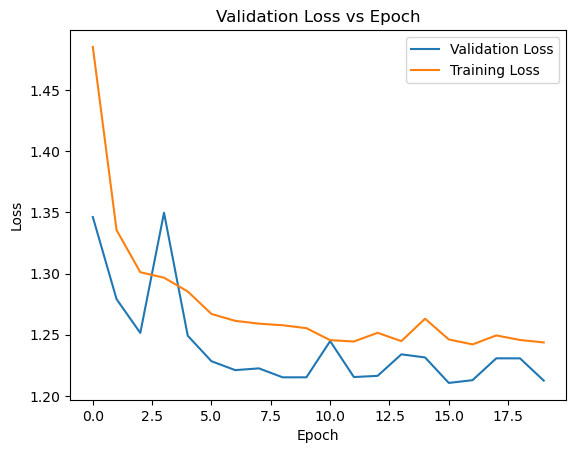

In [74]:
#plot des loss
plt.plot(val_losses)
plt.plot(train_losses)
plt.legend(['Validation Loss', 'Training Loss'])
plt.plot()
plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.title('Validation Loss vs Epoch')
plt.show()

Nous pouvons voir ici l'évolution de la loss de notre modèle sur les données de validation et de train. Nous remarquons que la fonction de perte pour la validation atteint un palier autour du 7-8 ème epochs, à partir de ce moment il devient difficile de réduire significativement sa valeur. 

In [21]:
model = MyEnhancedModel()
model.load_state_dict(torch.load('./models/final_model.pth')) # Nous reprenons notre meilleur modèle qui a été entraîné comme vu précedemment
model = model.to(device) 
model.eval()
with torch.no_grad(): # Nous ne voulons plus entraîner notre modèle
    test_loss = 0
    correct = 0
    total = 0
    for signals, snr, labels in test_loader:
        output = model(signals, snr)
        test_loss += criterion(output, labels).item()
        _, predicted = torch.max(output, 1)
        _, labels = torch.max(labels,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Accuracy: {correct / total}') 
    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss}')

/tmp/ipykernel_1985484/1836517527.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/final_model.pth'))


Accuracy: 0.8455
Test Loss: 5.096676546856643


Nous pouvons voir que nous obtenons finalement une accuracy de 0.8455, ce qui est bien au dessus de notre modèle initial qui était à 0.21

In [22]:
count_n_param(model)

1668166

Nous pouvons remarquer que nous avons 1 668 166 paramètres dans ce modèle. Ceci est normal car nous avons voulu faire des couches cachées plus grandes pour prendre plus d'informations sur le signal afin d'avoir un espace latent en 6 dimensions qui contiennent le plus d'informations possibles. 
Nous avons donc une précision bien meilleure sur notre modèle final, mais avec plus de 1 000 fois plus de paramètres. Ce qui n'est donc pas vraiment comparables, car il faut bien plus de puissances de calcul pour entraîner ce dernier.

## Synthèse de résultats 

Une fois que votre ou vos réseaux sont entrainez vous comparez leurs performances selon les métriques définies en introduction sur l'ensemble de test sans oublier de mesurer également la complexité de chaque approche en termes de nombre de paramètres. Si vous avez testé des approches qui vous semblent avoir échoué vous pouvez rédiger un petit paragraphe pour expliquer votre analyse de cet échec. 

### Tentative de LSTM

Après avoir essayer nos premiers modèles de convolution, nous avons voulu essayer des modèles LSTM. Ces essais n'ont pas été concluant, même en ayant des réseaux avec de nombreux paramètres comme celui ci-dessous, nous avons que difficilement passé la barre des 0.16 pour l'accuracy. Cela n'a donc pas été encourageant et nous avons préféré nous concentrer sur l'optimisation d'un modèle de convolution

In [ ]:
## Tentative de modèle LSTM##

class MyModel2(torch.nn.Module):     
    def __init__(self):
        super(MyModel2, self).__init__()
        self.rnn1 = torch.nn.LSTM(input_size=2, hidden_size=16, num_layers=1, batch_first=True, bidirectional=True)
        self.rnn2 = torch.nn.LSTM(input_size=32, hidden_size=16, num_layers=1, batch_first=True, bidirectional=True)
        self.rnn3 = torch.nn.LSTM(input_size=32, hidden_size=16, num_layers=1, batch_first=True, bidirectional=True)
        
       
        self.fc1 = torch.nn.Linear(16 * 2 * 2048, 1024)
        self.fc2 = torch.nn.Linear(1025, 256)
        self.fc3 = torch.nn.Linear(256, 6)
        
    def forward(self, x, snr):
        # Les RNN prennent (batch_size, seq_length, input_size), donc on permute les dimensions
        x = x.permute(0, 2, 1)  # (batch_size, seq_length, num_channels)
        

        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        x, _ = self.rnn3(x)
        
        # Aplatir pour passer aux couches fully connected
        x = x.contiguous().view(x.size(0), -1)
        

        x = torch.nn.functional.relu(self.fc1(x))
        snr = snr.unsqueeze(1)
        x = torch.cat([x, snr], dim=1)
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        
        return torch.softmax(x, dim=1)

### Conclusion

En conclusion, notre modèle final est basé sur des couches de convolutions comprenant près de 1 700 000 paramètres. Nous l'avons complexifié au fur et à mesure de notre étude, notamment en y ajoutant des couches de pooling et de dropout. Enfin l'augmentation de données a permis de freiner l'arrivée du surajustement et donc d'améliorer les performances de notre modèle. Au final nous arrivons à un modèle qui a une précision de près de 85 %  sur des signaux audios de 6 classes différentes, qui surclasse largement notre premier modèle et sa précision de 20 %. 